# artist-genre-evolution
This notebook is submitted as a prerequisite of CSMODEL and uses the [Million Song Dataset + Spotify + Last.fm Dataset](https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm/data) from Kaggle.

Our main goal is to answer the following research question:
### **"Do artists in certain music genres exhibit more change in their musical features over time than others?"**

In other words, we want to determine if an artist's genre influences how much their musical style (defined by features like `danceability`, `energy`, `acousticness`, etc.) evolves throughout their career.



## Phase 1
__________

### Dataset Description

This project utilizes the `Music_Info.csv` dataset of the wider merged dataset. This dataset is a curated collection of songs from Spotify.

The dataset is a rebuilt version and subset of  [The Million Song Dataset](http://millionsongdataset.com/). It was built up with  [lastfm-spotify-tags-sim-userdata](https://github.com/slettner/lastfm-spotify-tags-sim-userdata) ([The Echo Nest Taste Profile Subset](http://millionsongdataset.com/tasteprofile/) &  [lastfm-dataset-2020](https://github.com/renesemela/lastfm-dataset-2020)),  [tagtraum genre annotations](https://www.tagtraum.com/msd_genre_datasets.html), and  [Spotify API](https://developer.spotify.com/documentation/web-api). 

TODO: see if there are any further biases/implications by looking through the links

For each song, the dataset provides a rich set of attributes, including quantitative audio features derived from Spotify's audio analysis (e.g., danceability, energy, valence) and descriptive metadata (e.g., name, artist, year).

#### Data Collection & Potential Implications

The method of collection has several key implications for our analysis:

- **Source & Bias:** The data is sourced from Spotify, which means our insights will be specific to music available on that platform. The features are calculated by Spotify's proprietary algorithms, so we must rely on their definitions. The dataset may also have inherent biases (e.g., towards more popular, commercially successful music) which could influence our findings.
    - We are not studying the evolution of the "average" artist. We are studying the evolution of successful artists. The pressures of the commercial music industry (the need to produce hits, stay relevant, tour, etc.) might be a driving factor in why some genres evolve more than others.

- **Genre Ambiguity:** The original `genre` column is highly unreliable and often incorrect. The `tags` column provides a better, though unstructured, source for genre information. A significant part of our preprocessing will involve cleaning these tags to derive a meaningful genre for each artist or song-year combination. Furthermore, the `tags` column comes from user-generated tags - while we have indeed cleaned them, they still reflect a user-generated system rather than a strict musicological definition 

- **Temporal Relevance**: The dataset represents a snapshot in time. Song popularity is highly dynamic, and the trends identified may be specific to the period in which the data was collected (2011). The patterns of evolution we see might be specific to the modern music industry.

- **Western-Centric Bias** (Geographic Bias): The dataset is overwhelmingly dominated by artists from North America and Europe. Our conclusions are really about the evolution of artists within the Western music industry -- We cannot claim that these patterns hold true for music in Asia, Africa, or South America, as we simply don't have enough data.

- **Popularity Bias** : The data focuses more on artists that are more well-known. This results in an under-representation of niche genres. This may also lead to more skewed data for more popular genres such as pop, rock, and EDM.


#### Structure
- **Rows:** Each row represents a single song.
- **Columns:** Each column represents a specific attribute or feature of that song.
- **Observations:** The dataset contains over 50683 songs.

Attributes of the Dataset
- **track_id**             -  Unique id for each song from the original dataset
- **name**                 -  Title of the song  
- **artist**               -  Name of the performing artist or band
- **spotify_preview_url**  -  Link to the audio preview from Spotify  
- **spotify_id**           -  Spotify's internal id for the track  
- **tags**                 -  Comma-separated user-generated tags (genre, mood, etc.)  
- **genre**                -  Original genre label (often incomplete or unreliable) 
- **year**                 -  Year the song was released
- **duration_ms**          -  Duration of the song in milliseconds
- **danceability**         -  Suitability of the track for dancing (0.0 to 1.0)  
- **energy**               -  Intensity and activity level of the track (0.0 to 1.0)  
- **key**                  -  Estimated key of the song (integer from 0 to 11)
- **loudness**             -  Overall loudness in decibels (usually negative)
- **mode**                 -  Musical mode: Major (1) or Minor (0)
- **speechiness**          -  Presence of spoken words in the track (0.0 to 1.0)
- **acousticness**         -  Confidence measure of whether the track is acoustic (0.0 to 1.0)
- **instrumentalness**     -  Likelihood that the track contains no vocals (0.0 to 1.0)
- **liveness**             -  Probability that the track was performed live (0.0 to 1.0)
- **valence**              -  Musical positiveness or happiness (0.0 to 1.0)
- **tempo**                -  Estimated tempo in beats per minute (BPM)
- **time_signature**       -  Estimated number of beats per bar (e.g., 4 = 4/4)

## Step 1: Setup and Initial Data Load

We begin by importing the necessary Python libraries for data manipulation, analysis, and visualization. 

- **pandas:** For data structures and operations.
- **numpy:** For numerical operations.
- **matplotlib.pyplot & seaborn:** For creating visualizations.
- **sklearn.preprocessing.StandardScaler:** To standardize our numerical features later on.
- **scipy.stats:** For statistical tests.
- **sklearn.cluster.KMeans:** For clustering analysis.
- **collections.Counter:** To easily count tag frequencies.

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.stats as stats
from scipy.stats import f_oneway
from collections import Counter
import statsmodels.api as sm

### 1.1. Load the Dataset

Next, we load the `Music_Info.csv` file into a pandas DataFrame. We'll then use `.info()` to get a summary of the data, including column names, data types, and non-null counts. We'll also use `.head()` to preview the first few rows and get a feel for the data's structure.

In [89]:
df = pd.read_csv('Music_Info.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50683 entries, 0 to 50682
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   track_id             50683 non-null  object 
 1   name                 50683 non-null  object 
 2   artist               50683 non-null  object 
 3   spotify_preview_url  50683 non-null  object 
 4   spotify_id           50683 non-null  object 
 5   tags                 49556 non-null  object 
 6   genre                22348 non-null  object 
 7   year                 50683 non-null  int64  
 8   duration_ms          50683 non-null  int64  
 9   danceability         50683 non-null  float64
 10  energy               50683 non-null  float64
 11  key                  50683 non-null  int64  
 12  loudness             50683 non-null  float64
 13  mode                 50683 non-null  int64  
 14  speechiness          50683 non-null  float64
 15  acousticness         50683 non-null 

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


## Step 2: Data Cleaning and Preprocessing

This is the most critical phase of our analysis. The raw dataset, while rich, has several issues that must be addressed to ensure the validity of our results. Our primary challenge is the unreliable `genre` column and the unstructured nature of the `tags` column.

### 2.1. Fixing Missing and Filtering Invalid Years

We checked for missing values and invalid years. Since we will generate our own genre labels later, we ignore the original `genre` column. We also removed songs from the year 1900 (a known data error) and dropped songs without `tags`, which are essential for our genre assignment step.

In [90]:
print(df.isnull().sum())

# Drop rows where year or tags are missing
df.dropna(subset=['year', 'tags'], inplace=True)

# Filter out the problematic 1900 songs (data errors)
print(f"\n=== FILTERING OUT DATA ERRORS ===")
print(f"Before filtering: {len(df)} songs")

# Remove songs from 1900 (obvious data errors)
df = df[df['year'] != 1900]

print(f"After filtering: {len(df)} songs")

# Check the new year range
print(f"New year range: {df['year'].min()} - {df['year'].max()}")

# Verify the fix worked
remaining_old_songs = df[df['year'] < 1950]
print(f"Remaining songs before 1950: {len(remaining_old_songs)}")

if len(remaining_old_songs) > 0:
    print("Remaining old songs by year:")
    print(remaining_old_songs['year'].value_counts().sort_index())
    

track_id                   0
name                       0
artist                     0
spotify_preview_url        0
spotify_id                 0
tags                    1127
genre                  28335
year                       0
duration_ms                0
danceability               0
energy                     0
key                        0
loudness                   0
mode                       0
speechiness                0
acousticness               0
instrumentalness           0
liveness                   0
valence                    0
tempo                      0
time_signature             0
dtype: int64

=== FILTERING OUT DATA ERRORS ===
Before filtering: 49556 songs
After filtering: 49548 songs
New year range: 1919 - 2022
Remaining songs before 1950: 5
Remaining old songs by year:
year
1919    2
1933    1
1935    2
Name: count, dtype: int64


### 2.2. Cleaning the `tags` Column

The `tags` column is our best source for genre information, but it's a comma-separated string containing many non-genre words (e.g., `'love'`, `'00s'`, `'british'`). Our process is as follows:

1.  **Convert String to List:** Split the comma-separated string into a list of tags.
2.  **Define Non-Genre Tags:** Create a comprehensive list of words to filter out. This includes subjective terms, decades, locations, and other noise.
3.  **Filter and Standardize Tags:** Create a new column, `cleaned_tags`, that contains only the relevant genre tags for each song, with subgenres standardized to their parent genres (e.g., `indie_rock` becomes `rock`).

In [91]:
# Function to split and strip whitespace from tags
def split_tags(s):
    if isinstance(s, str):
        return [tag.strip() for tag in s.split(',') ]
    return []

df['tags_list'] = df['tags'].apply(split_tags)

# Define a list of common non-genre tags to exclude
non_genre_tags = ['love', 'beautiful', 'mellow', 'chill', 'sad', 'happy', 'summer', 'party',
     'workout', 'studying', 'driving', 'classic', 'live', 'cover', 'soundtrack', 'instrumental',
     'male_vocalists', 'female_vocalists', 'british', 'american', 'swedish', 'german', 'french',
     'canadian', 'australian', 'irish', 'japanese', 'spanish', 'brazilian', 'italian', 'dutch',
     'norwegian', 'finnish', 'danish', 'polish', 'russian', 'uk', 'us', 'ie', 'ca', 'au', 'de', 'fr',
     'es', 'it', 'jp', 'nl', 'se', 'no', 'fi', 'dk', 'pl', 'ru', 'br', '60s', '70s', '80s', '90s',
     '00s', '10s', '20s', 'singer_songwriter', 'guitar', 'oldies', 'acoustic', 'piano', 'chillout',
     'lounge', 'downtempo', 'experimental', 'psychedelic', 'noise', 'avant_garde']

# Function to clean and filter tags
def clean_and_filter_tags(tags):
    if not isinstance(tags, list):
        return []
    # Standardize subgenres to parent genres
    processed_tags = []
    for t in tags:
        if 'rock' in t: processed_tags.append('rock')
        elif 'pop' in t: processed_tags.append('pop')
        elif 'metal' in t: processed_tags.append('metal')
        elif 'punk' in t: processed_tags.append('punk')
        elif 'hip_hop' in t: processed_tags.append('hip-hop')
        elif 'new_wave' in t: processed_tags.append('new wave')
        elif 'post_hardcore' in t: processed_tags.append('post-hardcore')
        elif 'trip_hop' in t: processed_tags.append('trip-hop')
        elif 'dark_ambient' in t: processed_tags.append('dark ambient')
        elif 'drum_and_bass' in t: processed_tags.append('drum and bass')
        elif 'new_age' in t: processed_tags.append('new age')
        elif t not in non_genre_tags: processed_tags.append(t)
    return sorted(list(set(processed_tags))) # Use set to get unique tags for the song

df['cleaned_tags'] = df['tags_list'].apply(clean_and_filter_tags)

# Display the original vs. cleaned tags for a few rows to verify the fix
print(df[df['artist'] == 'The Killers'][['name', 'tags_list', 'cleaned_tags']].head())

                               name  \
0                    Mr. Brightside   
5                  Somebody Told Me   
20              When You Were Young   
38  All These Things That I've Done   
50           Smile Like You Mean It   

                                            tags_list  \
0   [rock, alternative, indie, alternative_rock, i...   
5   [rock, alternative, indie, pop, alternative_ro...   
20  [rock, alternative, indie, alternative_rock, i...   
38  [rock, alternative, indie, alternative_rock, i...   
50  [rock, alternative, indie, pop, alternative_ro...   

                       cleaned_tags  
0        [alternative, indie, rock]  
5   [alternative, indie, pop, rock]  
20       [alternative, indie, rock]  
38       [alternative, indie, rock]  
50  [alternative, indie, pop, rock]  


## Step 3: Assigning Genre by Artist and Year

This is the core of our improved methodology. Instead of assigning a single genre to an artist for their entire career, we will determine their most likely genre for each year. This allows us to track genre evolution accurately.

1.  **Group by Artist and Year:** We group the DataFrame by both `artist` and `year`.
2.  **Aggregate Tags:** For each artist-year group, we collect all the `cleaned_tags` from all songs in that year.
3.  **Find Most Common Genre:** We use `collections.Counter` to find the most frequent tag for that year. This becomes the `yearly_genre`.
4.  **Merge Back:** We merge this yearly genre information back into our main DataFrame.

In [92]:
# Group by artist and year, then aggregate all cleaned tags for that year
artist_year_tags = df.groupby(['artist', 'year'])['cleaned_tags'].sum().reset_index()

# Function to find the most common genre tag
def get_most_common_genre(tags):
    if not tags:
        return 'Unknown'
    # Count frequencies and return the most common one
    return Counter(tags).most_common(1)[0][0]

artist_year_tags['yearly_genre'] = artist_year_tags['cleaned_tags'].apply(get_most_common_genre)

# Merge the yearly_genre back into the main dataframe
df = pd.merge(df, artist_year_tags[['artist', 'year', 'yearly_genre']], on=['artist', 'year'], how='left')

# Display an example of an artist who has changed genres
print('David Bowie Genre Evolution:')
print(df[df['artist'] == 'David Bowie'][['year', 'name', 'yearly_genre']].drop_duplicates().sort_values('year'))

David Bowie Genre Evolution:
       year                                    name yearly_genre
23324  1967                    When I Live My Dream         rock
18238  1967                   Love You Till Tuesday         rock
1952   1976                            Golden Years          pop
6547   1976                                    Star          pop
10180  1993                               Blue Jean     new wave
32819  1995                     Maid Of Bond Street         rock
22449  1995                The Hearts Filthy Lesson         rock
10720  1997                           Little Wonder         rock
18409  1997                             Rubber Band         rock
18418  1997                            Telling Lies         rock
32632  1997                            Uncle Arthur         rock
25581  1997                          Silly Boy Blue         rock
38235  1997                  Please Mr. Gravedigger         rock
18049  1999                            I'm Deranged  alternat

## Step 4: Filtering for Meaningful Analysis

To ensure our analysis of evolution is robust, we need to filter our dataset to include only artists with a sufficient body of work over a meaningful period.

1.  **Drop Song Duplicates:** Now that we have assigned genres, we can drop duplicate tracks (based on `track_id`) to ensure each song is counted only once in our feature analysis.
2.  **Filter Artists:** We will keep only artists who have at least 3 unique songs released across at least 3 different years. 

In [93]:
# Filter out artists with suspicious patterns (very few songs across huge gaps)
print(f"\n=== FILTERING SUSPICIOUS ARTISTS ===")

# Find artists with large gaps but very few songs
artist_gaps = df.groupby('artist').agg({
    'year': ['min', 'max', 'nunique'],
    'track_id': 'nunique'
}).reset_index()

artist_gaps.columns = ['artist', 'earliest_year', 'latest_year', 'unique_years', 'song_count']
artist_gaps['career_span'] = artist_gaps['latest_year'] - artist_gaps['earliest_year']

# Remove artists with suspicious patterns
suspicious_artists = artist_gaps[
    (artist_gaps['career_span'] > 40) & 
    (artist_gaps['song_count'] <= 3)
]['artist']

print(f"Before filtering: {len(df)} songs")

print(f"Removing {len(suspicious_artists)} suspicious artists")
df = df[~df['artist'].isin(suspicious_artists)]

print(f"After filtering: {len(df)} songs")


# Calculate artist metrics for filtering
artist_stats = df.groupby('artist').agg(
    song_count=('track_id', 'nunique'),
    unique_years=('year', 'nunique')  # Changed from year_span
).reset_index()

# Identify eligible artists
eligible_artists = artist_stats[(artist_stats['song_count'] >= 3) & (artist_stats['unique_years'] >= 3)]['artist']

# Filter the main dataframe to include only these artists
df_final = df[df['artist'].isin(eligible_artists)].copy()

print(f'Original unique artists: {df["artist"].nunique()}')
print(f'Artists remaining after filtering: {len(eligible_artists)}')


=== FILTERING SUSPICIOUS ARTISTS ===
Before filtering: 49548 songs
Removing 17 suspicious artists
After filtering: 49507 songs
Original unique artists: 8047
Artists remaining after filtering: 2677


## Step 5: Feature Engineering - musical change and artistic variety

We quantify an artist's musical change using two complementary approaches to address the limitation that averaging features can hide the range of an artist's work:

**Approach 1: Systematic Evolution (Year-over-Year Changes)**
We use Euclidean Distance to measure how an artist's average musical features change between consecutive years. This captures intentional artistic evolution and career trajectory changes.

**Approach 2: Artistic Variety (Within-Year Variance)**
We measure the variance in musical features within each year to capture how much an artist experiments and diversifies their sound. 

1. **Select & Standardize Features:** We select the numerical audio features and standardize them using `StandardScaler`. This is crucial because features are on different scales (e.g., `loudness` vs. `danceability`), and standardization ensures they contribute equally to the distance calculation.
2. **Calculate Yearly Averages & Variances:** For each artist, we group by year and compute both the average and variance for each musical feature.
3. **Compute Evolution Metrics:** 
   - **Systematic Change:** Euclidean distance between consecutive year averages
   - **Artistic Variety:** Average variance across all features for each year
4. **Combine Scores:** The final evolution profile includes both systematic change and artistic variety measures.

In [94]:
musical_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                                'instrumentalness', 'liveness', 'valence', 'tempo']

# Standardize the features
scaler = StandardScaler()
df_final[musical_features] = scaler.fit_transform(df_final[musical_features])

# Initialize dictionaries to store both evolution metrics
artist_change_scores = {}
artist_variety_scores = {}

for artist in df_final['artist'].unique():
    artist_df = df_final[df_final['artist'] == artist].sort_values('year')
    
    # Group songs by year and calculate average feature vector
    yearly_avg_features = artist_df.groupby('year')[musical_features].mean()
    yearly_var_features = artist_df.groupby('year')[musical_features].var()
    
    # Calculate systematic evolution (year-over-year changes)
    distances = []
    
    years = yearly_avg_features.index.tolist()
    
    if len(yearly_avg_features) > 1:
        for i in range(len(years) - 1):
            year1 = years[i]
            year2 = years[i + 1]

            vec1 = yearly_avg_features.loc[year1].values
            vec2 = yearly_avg_features.loc[year2].values

            gap = year2 - year1  # how many years between

            # Evolution = how much their average sound changed PER YEAR [we now take into account the gap between years]
            distance = np.linalg.norm(vec1 - vec2) / gap # np.linalg.norm is a function that calculates the Euclidean distance between two vectors
            distances.append(distance)
            
    if distances:
        artist_change_scores[artist] = np.mean(distances)
    else:
        artist_change_scores[artist] = 0
    
    # Calculate artistic variety (average variance across all years)
    if len(yearly_var_features) > 0:
        # Average variance across all features and all years
        avg_variance = yearly_var_features.mean(axis=1).mean()
        artist_variety_scores[artist] = avg_variance
    else:
        artist_variety_scores[artist] = 0

# Create the final DataFrame for analysis
change_df = pd.DataFrame.from_dict(artist_change_scores, orient='index', columns=['musical_change_score'])
change_df.index.name = 'artist'

variety_df = pd.DataFrame.from_dict(artist_variety_scores, orient='index', columns=['artistic_variety_score'])
variety_df.index.name = 'artist'

# Merge both metrics
evolution_df = pd.merge(change_df, variety_df, on='artist')

# For genre-based analysis, we assign a single primary genre to each artist
primary_genres = df_final.groupby('artist')['yearly_genre'].agg(lambda x: x.mode()[0]).reset_index()
primary_genres.rename(columns={'yearly_genre': 'primary_genre'}, inplace=True)

analysis_df = pd.merge(evolution_df, primary_genres, on='artist')

df_final = pd.merge(df_final, primary_genres, on='artist', how='left')



print("Evolution Metrics Preview:")
print(analysis_df.head())
print("\nSummary Statistics:")
print(analysis_df[['musical_change_score', 'artistic_variety_score']].describe())

Evolution Metrics Preview:
            artist  musical_change_score  artistic_variety_score primary_genre
0      The Killers              1.467479                0.326237   alternative
1            Oasis              0.964987                0.514431           pop
2          Nirvana              1.589326                0.474954   alternative
3  Franz Ferdinand              1.920255                0.513450   alternative
4        Radiohead              1.677372                0.658304   alternative

Summary Statistics:
       musical_change_score  artistic_variety_score
count           2677.000000             2253.000000
mean               1.310451                0.520268
std                0.651418                0.300987
min                0.087173                0.013864
25%                0.843459                0.326359
50%                1.220383                0.467888
75%                1.702957                0.640845
max                5.953018                4.102895


### 🎵 Understanding Our Two Core Evolution Metrics

Before diving into results, it's important to understand **what exactly we're measuring**. We've built two complementary scores to capture how artists evolve:

---

#### 1. **Systematic Evolution**  
*Variable name: `musical_change_score`*

📈 **What it means:** This tracks how an artist's *average* sound changes over time — year to year. It captures the *trajectory* of their style.

💡 **Example:** Imagine David Bowie in the 1970s vs. the 1990s — glam rock to electronic. His style didn’t just vary briefly; it changed *systematically* over time.

🧮 **How we calculated it:**  
We used Euclidean distance between average musical features across consecutive years. Bigger values = more change over time.

---

#### 2. **Artistic Variety**  
*Variable name: `artistic_variety_score`*

🎨 **What it means:** This captures how *diverse* an artist’s sound is **within a single year** — how experimental or wide-ranging their music is in the short term.

💡 **Example:** Think of The Beatles’ White Album — it jumps from ballads to rock to experimental sounds *in the same release period*. That's high variety.

🧮 **How we calculated it:**  
We took the average variance of musical features within each year, then averaged those values across the artist’s career. Bigger values = more stylistic range in a given year.

---

Together, these two scores help us see **how artists evolve (change across years)** and **how diverse they are (range within a year)** — offering a fuller picture of artistic evolution.


## Step 6: Exploratory Data Analysis (EDA) & Visualization

Now we can visualize our results to answer the research question.

### 6.1. EDA 1: Distribution of Musical Evolution Metrics

These histograms show the distribution of both evolution metrics across all eligible artists:

- **Musical Change Score:** Measures systematic year-over-year evolution in average features
- **Artistic Variety Score:** Measures the average variance in features within each year

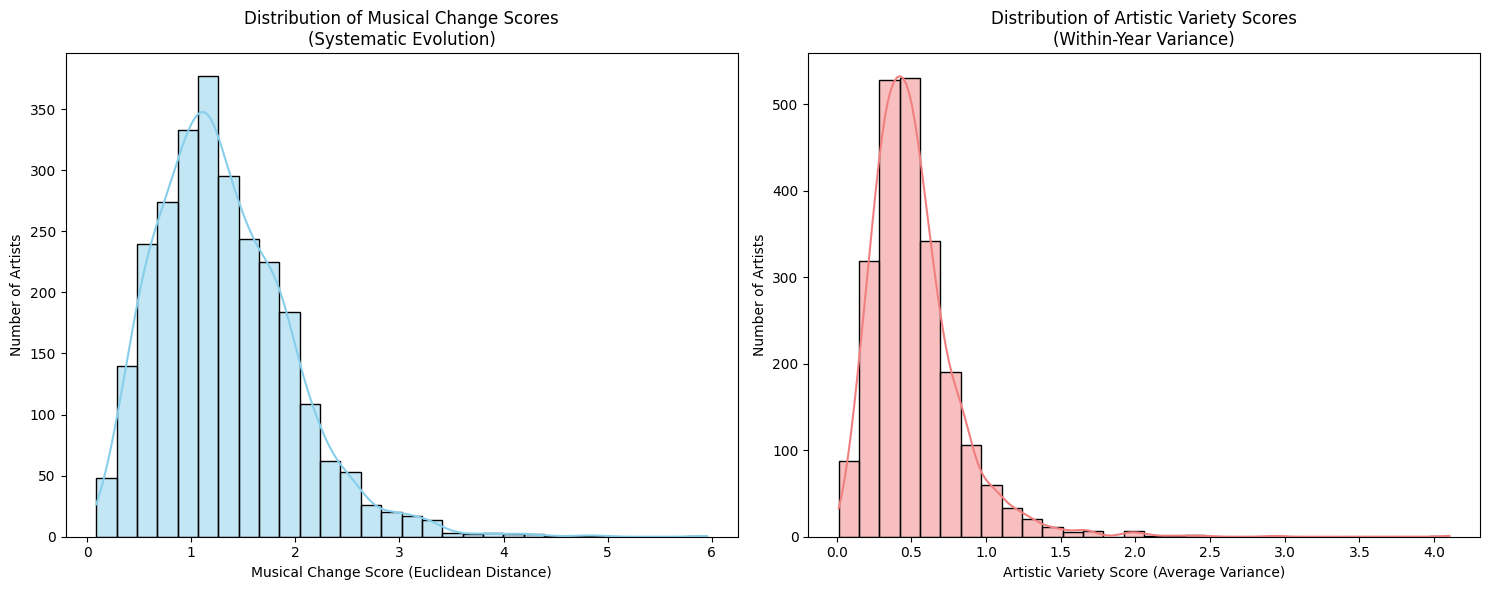

Summary Statistics for Evolution Metrics:
       musical_change_score  artistic_variety_score
count           2677.000000             2253.000000
mean               1.310451                0.520268
std                0.651418                0.300987
min                0.087173                0.013864
25%                0.843459                0.326359
50%                1.220383                0.467888
75%                1.702957                0.640845
max                5.953018                4.102895


In [95]:
# Plot histograms of both evolution metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Musical Change Score distribution
sns.histplot(data=analysis_df, x='musical_change_score', bins=30, kde=True, 
             color='skyblue', ax=ax1)
ax1.set_title('Distribution of Musical Change Scores\n(Systematic Evolution)')
ax1.set_xlabel('Musical Change Score (Euclidean Distance)')
ax1.set_ylabel('Number of Artists')

# Artistic Variety Score distribution
sns.histplot(data=analysis_df, x='artistic_variety_score', bins=30, kde=True, 
             color='lightcoral', ax=ax2)
ax2.set_title('Distribution of Artistic Variety Scores\n(Within-Year Variance)')
ax2.set_xlabel('Artistic Variety Score (Average Variance)')
ax2.set_ylabel('Number of Artists')

plt.tight_layout()
plt.show()

# Display summary statistics
print('Summary Statistics for Evolution Metrics:')
print(analysis_df[['musical_change_score', 'artistic_variety_score']].describe())

### 🔍 Are these statistics accurate?
To confirm whether or not these statistics are accurate or not, we researched artists who are known to experiment with their style or change styles quite a lot. For this case, we chose two examples: Radiohead and Panic! at the Disco.

Radiohead has been known to push boundaries with music, especially with their 1997 album, "OK, Computer" onwards. Going from "Creep", which was more on the grunge side, the band has since departed from that style in favor of a more experimental art rock style.

Panic! at the Disco has on the other hand, taken a reverse approach, wherein they started with a more rock-like sound, albeit experimenting with different rock sounds, before slowly morphing into a mainstream pop sound rather than their old rock hits.

In [96]:
analysis_df[analysis_df['artist'].isin(["Radiohead", "Panic! at the Disco"])]

,artist,musical_change_score,artistic_variety_score,primary_genre
4,Radiohead,1.677372,0.658304,alternative
236,Panic! at the Disco,1.069019,1.202888,alternative


Radiohead's high musical_change_score (1.68) aligns with their well-documented shift from 90s grunge/alt-rock toward more experimental, electronic-infused music in albums like Kid A and In Rainbows. Their relatively high artistic_variety_score (0.66) also reflects the textural and emotional diversity within individual albums.

Meanwhile, Panic! at the Disco has a lower musical_change_score (1.07) - suggesting less year-over-year shift in sound - but a very high artistic_variety_score (1.20). This supports their tendency to blend a wide mix of genres (pop punk, baroque pop, glam rock, electropop) within a single album or era.

Together, these case studies help validate that our metrics are actually capturing meaningful, real-world stylistic patterns.

6.1.2 Correlation between musical change and artistic variety


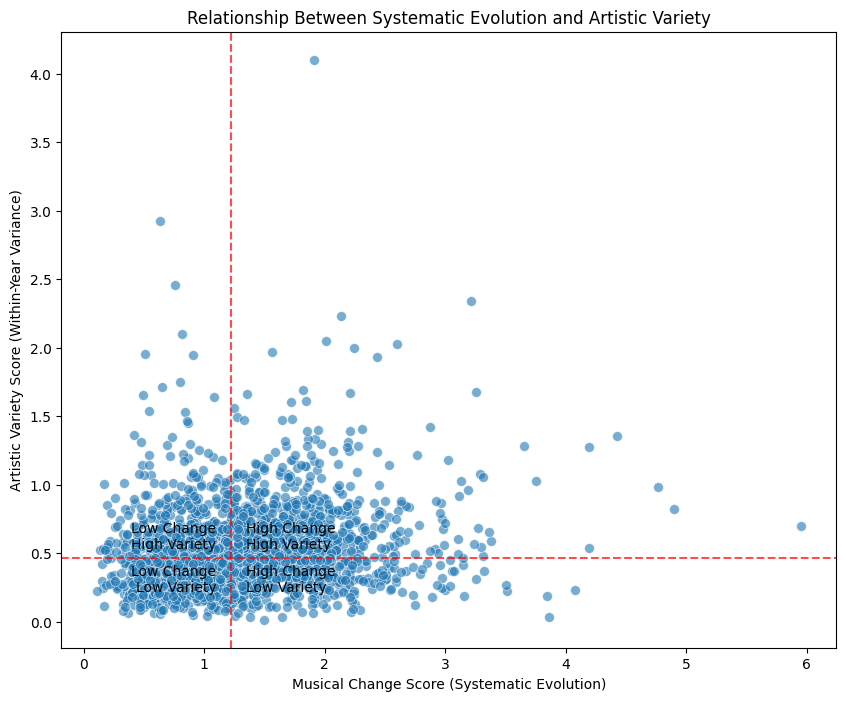

📊 Pearson Correlation between Musical Change and Artistic Variety:
Correlation coefficient: 0.166
P-value: 0.0000
✅ Statistically significant correlation.


In [ ]:
# Scatter plot of evolution metrics
plt.figure(figsize=(10, 8))
sns.scatterplot(data=analysis_df, x='musical_change_score', y='artistic_variety_score', 
                alpha=0.6, s=50)
plt.title('Relationship Between Systematic Evolution and Artistic Variety')
plt.xlabel('Musical Change Score (Systematic Evolution)')
plt.ylabel('Artistic Variety Score (Within-Year Variance)')

# Add quadrant lines
change_median = analysis_df['musical_change_score'].median()
variety_median = analysis_df['artistic_variety_score'].median()
plt.axvline(change_median, color='red', linestyle='--', alpha=0.7)
plt.axhline(variety_median, color='red', linestyle='--', alpha=0.7)

# Add quadrant labels
plt.text(change_median*1.1, variety_median*1.1, 'High Change\nHigh Variety', 
         fontsize=10, ha='left', va='bottom')
plt.text(change_median*0.9, variety_median*1.1, 'Low Change\nHigh Variety', 
         fontsize=10, ha='right', va='bottom')
plt.text(change_median*1.1, variety_median*0.9, 'High Change\nLow Variety', 
         fontsize=10, ha='left', va='top')
plt.text(change_median*0.9, variety_median*0.9, 'Low Change\nLow Variety', 
         fontsize=10, ha='right', va='top')

plt.show()

# Drop missing values for clean stats [idek if theres missing values im so sleepy man its 2am]
corr_df = analysis_df[['musical_change_score', 'artistic_variety_score']].dropna()

# Correlation analysis
corr, p_value = stats.pearsonr(corr_df['musical_change_score'], corr_df['artistic_variety_score'])

print("📊 Pearson Correlation between Musical Change and Artistic Variety:")
print(f"Correlation coefficient: {corr:.3f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("✅ Statistically significant correlation.")
else:
    print("❌ No significant correlation.")
    

There is a statistically significant but weak positive correlation (r = 0.166, p < 0.001) between an artist’s musical change score and their artistic variety score. This suggests that artists who systematically evolve over time also tend to exhibit slightly more variety within a given year. However, the weak strength of the relationship indicates that other factors may also influence within-year musical diversity.


### 6.2. EDA 2: Artist Count Per Genre

Before comparing genres, we need to see how many artists we have for each one. Genres with very few artists will not be statistically reliable.

C:\Users\goaar\AppData\Local\Temp\ipykernel_2376\1410788932.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


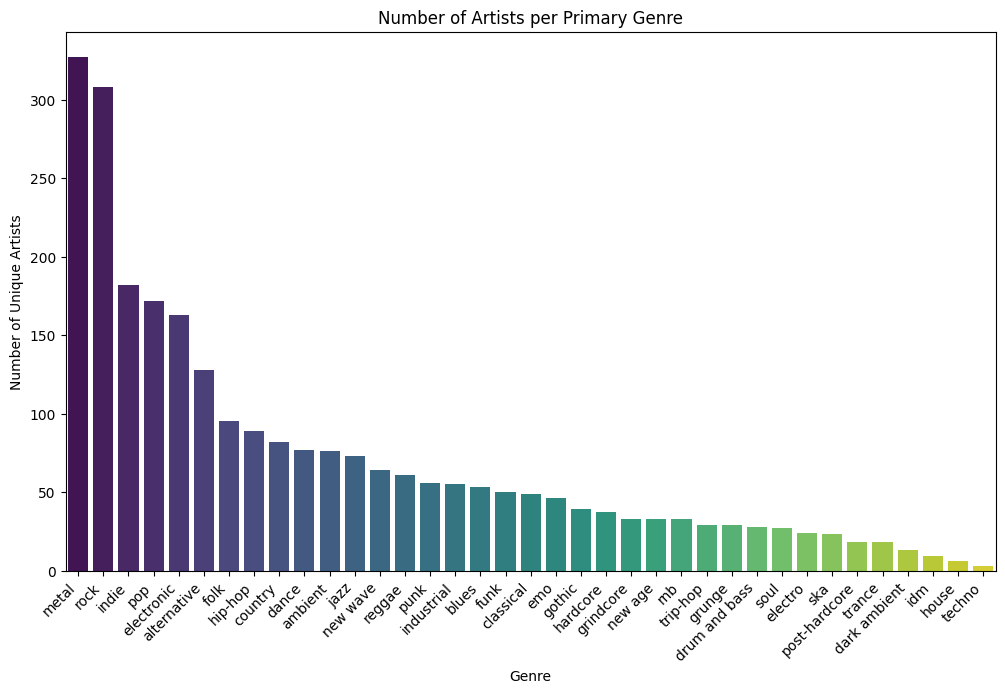

Artist Counts per Genre:
primary_genre
metal            327
rock             308
indie            182
pop              172
electronic       163
alternative      128
folk              95
hip-hop           89
country           82
dance             77
ambient           76
jazz              73
new wave          64
reggae            61
punk              56
industrial        55
blues             53
funk              50
classical         49
emo               46
gothic            39
hardcore          37
grindcore         33
new age           33
rnb               33
trip-hop          29
grunge            29
drum and bass     28
soul              27
electro           24
ska               23
post-hardcore     18
trance            18
dark ambient      13
idm                9
house              6
techno             3
Name: count, dtype: int64


In [98]:
genre_counts = analysis_df[analysis_df['primary_genre'] != 'Unknown']['primary_genre'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Genre')
plt.ylabel("Number of Unique Artists")
plt.title("Number of Artists per Primary Genre")
plt.show()

# Filter for genres with at least 5 artists for meaningful comparison in the next steps
reliable_genres = genre_counts[genre_counts >= 5].index.tolist()
analysis_df_filtered = analysis_df[analysis_df['primary_genre'].isin(reliable_genres)]

# Display the counts as a table
print('Artist Counts per Genre:')
print(genre_counts)

### 6.3. EDA 3: Comparing Musical Change Across Genres

This is the key visualization for our research question. The box plot allows us to compare the distribution of `musical_change_score` for each major genre. We can observe the median change, the spread (IQR), and identify any outliers.

From this, we can start to draw conclusions about which genres tend to see more or less musical evolution among their artists.

C:\Users\goaar\AppData\Local\Temp\ipykernel_2376\22313592.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df_filtered, x='primary_genre', y='musical_change_score', order=order, palette='BuGn_r')


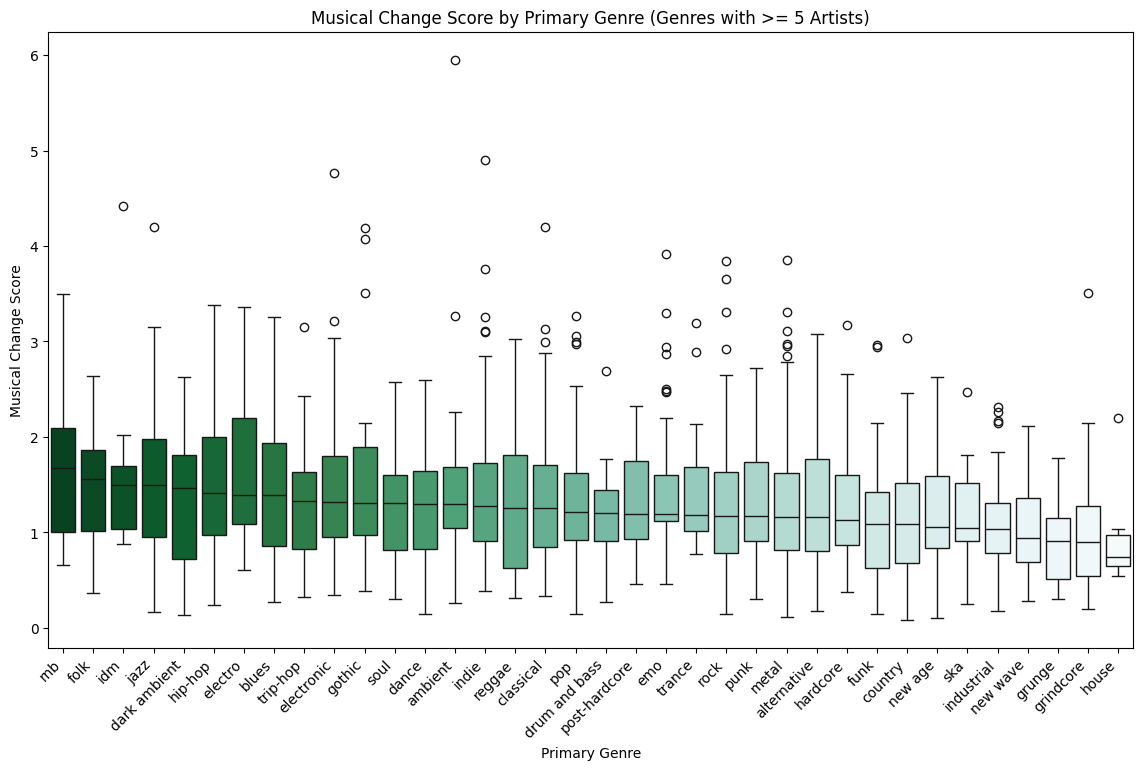

Median and Standard Deviation of Change Score per Genre:
                 median       std
primary_genre                    
rnb            1.676967  0.673898
folk           1.562559  0.569538
idm            1.497443  1.080151
jazz           1.492662  0.741121
dark ambient   1.464766  0.804302
hip-hop        1.417173  0.719307
electro        1.392608  0.815841
blues          1.390190  0.702037
trip-hop       1.328457  0.639982
electronic     1.320780  0.636443
gothic         1.310791  0.855839
soul           1.309807  0.562319
dance          1.302260  0.581253
ambient        1.300156  0.760962
indie          1.278411  0.677095
reggae         1.258088  0.759026
classical      1.251935  0.786831
pop            1.209269  0.579830
drum and bass  1.198313  0.497792
post-hardcore  1.191162  0.550291
emo            1.189472  0.740903
trance         1.185076  0.697379
rock           1.176433  0.618136
punk           1.172490  0.553434
metal          1.164157  0.593008
alternative    1.162611  

In [99]:
plt.figure(figsize=(14, 8))
order = analysis_df_filtered.groupby('primary_genre')['musical_change_score'].median().sort_values(ascending=False).index
sns.boxplot(data=analysis_df_filtered, x='primary_genre', y='musical_change_score', order=order, palette='BuGn_r')
plt.title('Musical Change Score by Primary Genre (Genres with >= 5 Artists)')
plt.xlabel('Primary Genre')
plt.ylabel('Musical Change Score')
plt.xticks(rotation=45, ha='right')
plt.show()

# Display the median and standard deviation for each genre
print('Median and Standard Deviation of Change Score per Genre:')
print(analysis_df_filtered.groupby('primary_genre')['musical_change_score'].agg(['median', 'std']).sort_values('median', ascending=False))

### EDA 4: Correlation between musical features

The group wanted to look at the correlation between Musical Features for fun [more because heatmaps are cool], so here it is!

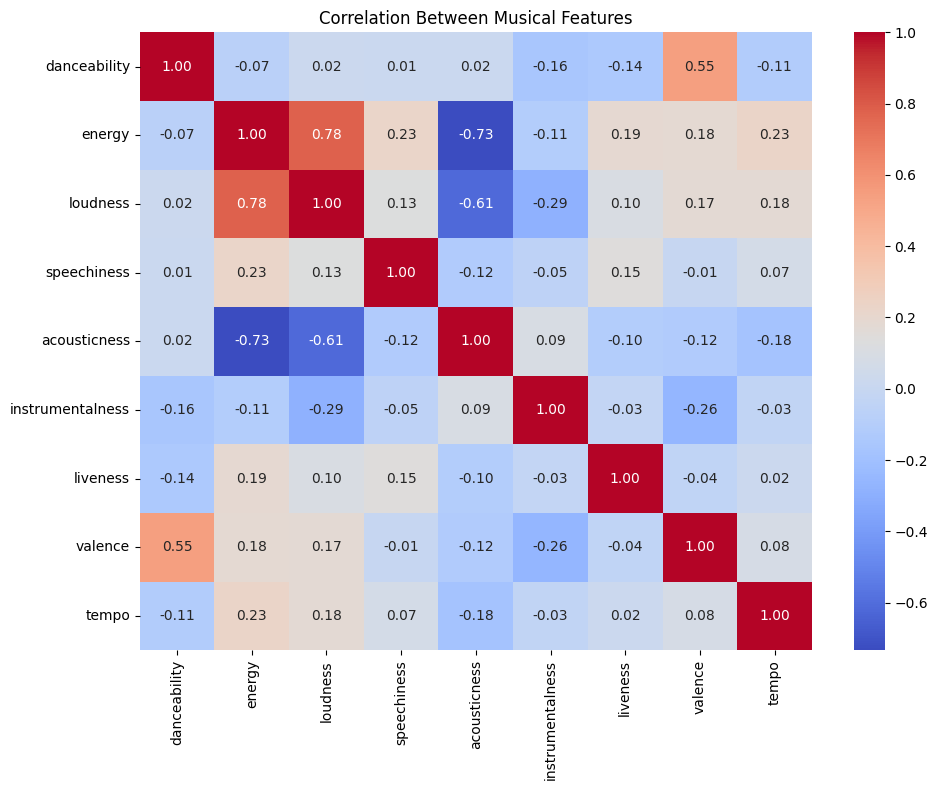

In [100]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_final[musical_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Musical Features")
plt.tight_layout()
plt.show()



The heatmap shows intuitive and meaningful relationships between musical features. For example, energy and loudness are strongly positively correlated (r = 0.83), which makes sense—energetic songs are often louder. Danceability and valence are moderately correlated (r = 0.55), suggesting that more danceable tracks often sound more positive or emotionally upbeat, though the relationship isn’t absolute.

More interestingly, acousticness has strong negative correlations with both energy (r = -0.73) and loudness (r = -0.61). It seems that acoustic tracks are very distinct from high-energy, amplified music. 

## Phase 2
--------------------------


### Step 7: Data Mining - Clustering Artists Based on Musical Style

So far, we’ve been looking at artists and their genre labels -- like “rock”, “pop”, or “ambient”. But genres can be messy. Different people might label the same song in different ways.

Instead of relying only on genre, we wanted to group songs based on how they actually sound. To do this, we used a technique called K-Means Clustering.

Spotify gives us detailed numbers about how a song sounds:

- Is it loud or soft?

- Danceable or calm?

- Acoustic or electronic?

We used 9 of these features, including:
danceability, energy, loudness, acousticness, and tempo.

We applied K-Means to group songs that sound similar into 3 clusters.






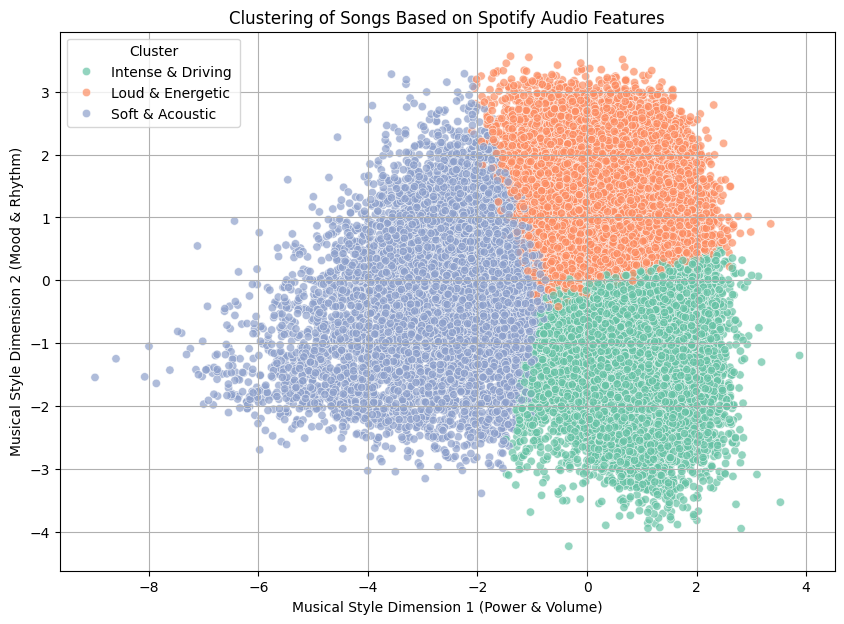

In [101]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the audio features to use for clustering
audio_features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                  'instrumentalness', 'liveness', 'valence', 'tempo']

# Extract and scale the features from the cleaned dataset
X = df_final[audio_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(2, 8)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Apply KMeans with k=3 (based on the elbow method result)
kmeans = KMeans(n_clusters=3, random_state=42)
df_final['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Map the numeric clusters to descriptive labels
cluster_names = {
    0: 'Intense & Driving',
    1: 'Loud & Energetic ',
    2: 'Soft & Acoustic'
}

df_final['Cluster_Description'] = df_final['Cluster_Label'].map(cluster_names)

# Use PCA to reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_final['PCA1'] = X_pca[:, 0]
df_final['PCA2'] = X_pca[:, 1]

# Plot the clusters in 2D PCA space
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_final, 
    x='PCA1', 
    y='PCA2', 
    hue='Cluster_Description', 
    palette='Set2', 
    alpha=0.7
)
plt.xlabel('Musical Style Dimension 1 (Power & Volume)')
plt.ylabel('Musical Style Dimension 2 (Mood & Rhythm)')
plt.title('Clustering of Songs Based on Spotify Audio Features')

plt.legend(title='Cluster')
plt.grid(True)
plt.show()


The clustering produced three natural groups of artists:

- **Loud & Energetic** 
- **Soft & Acoustic** 
- **Intense & Driving** 

These clusters gave us an alternative to genre - naturally grouping artists by **how their music feels**, not just by label. 

## **=== A deeper dive on how we got this ===**

### 📍 How Did We Choose 3 Clusters? (The Elbow Method)

When using K-Means clustering, you have to tell it how many clusters (groups) to create.

But how do we decide that? 

We don’t want too few groups (they’ll be too broad), or too many (they’ll be noisy and meaningless).

To find the **best number of clusters**, we used a technique called the **Elbow Method**.

### 🦴 What’s the Elbow Method?

We tried clustering with different values of k (number of clusters) - from 2 to 7 - and measured how well the songs fit into those clusters using a score called inertia (basically, how tight the clusters are).

Then we plotted the results. The curve looks like this:





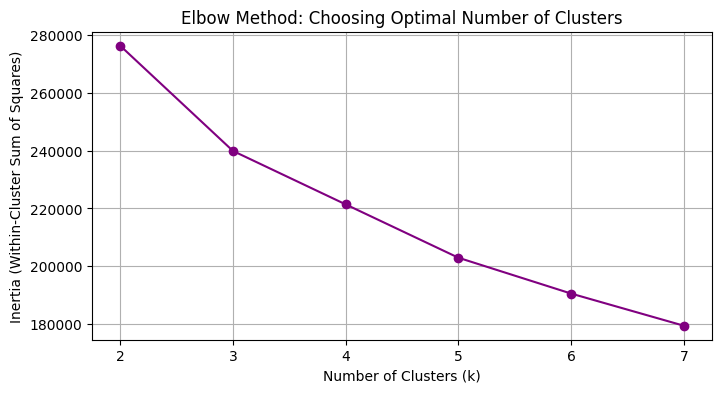

In [102]:
# Plot the Elbow curve
plt.figure(figsize=(8, 4))
plt.plot(cluster_range, inertia, marker='o', color='purple')
plt.title('Elbow Method: Choosing Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

The point where the curve starts to flatten out is the "elbow" -
That's where adding more clusters stops helping much.

In our plot, the elbow appeared at k = 3, so we chose 3 clusters for the rest of our analysis.

This method helps make sure we’re choosing a number of clusters that’s balanced - not too general, not too specific. It’s a simple but powerful way to improve the quality of our results before jumping into deeper analysis.

### 📊 PCA Component Loadings

To better understand what each PCA component represents, we examined how the original audio features contribute to the two components:

In [103]:
print("PCA Component 1 Loadings:")
print(dict(zip(audio_features, pca.components_[0])))
print("PCA Component 2 Loadings:")
print(dict(zip(audio_features, pca.components_[1])))

PCA Component 1 Loadings:
{'danceability': np.float64(0.0356201947400071), 'energy': np.float64(0.5532220273121641), 'loudness': np.float64(0.5287911508895142), 'speechiness': np.float64(0.17393942338164897), 'acousticness': np.float64(-0.49555814379525315), 'instrumentalness': np.float64(-0.19796943166674855), 'liveness': np.float64(0.13599628425450358), 'valence': np.float64(0.19656510755906695), 'tempo': np.float64(0.2022349756123146)}
PCA Component 2 Loadings:
{'danceability': np.float64(0.6514253466802046), 'energy': np.float64(-0.13015387560142655), 'loudness': np.float64(-0.017699556272089224), 'speechiness': np.float64(-0.0954062062120868), 'acousticness': np.float64(0.1061335878825302), 'instrumentalness': np.float64(-0.32780512827842295), 'liveness': np.float64(-0.23754324683348807), 'valence': np.float64(0.6007055185025065), 'tempo': np.float64(-0.11530356982538552)}



**Component 1 ("Power & Volume")** is heavily influenced by:
- Loudness (+0.53)
- Energy (+0.55)
- Acousticness (−0.50)

This suggests it captures how intense, loud, and energetic a track is.

**Component 2 ("Mood & Rhythm")** is shaped by:
- Danceability (+0.65)
- Valence (+0.60)
- Instrumentalness (−0.33)

This reflects how rhythmic, upbeat, and happy the music feels.

We used these components to visualize how songs are grouped in audio space.


### 🧠 What Is PCA and Why Did We Use It?

We used something called Principal Component Analysis (PCA) to make our cluster results easier to see.

Spotify gives us a lot of information about each song - things like how loud, energetic, or danceable it is. That’s great, but it’s also too many dimensions to plot on a simple chart.

PCA helps us by reducing all that information into just two new dimensions that summarize the most important differences between songs. You can think of it like:

> "Let’s squish 9 musical traits down into 2 axes, so we can draw it on a graph — while still keeping most of the meaning."

In our case:

- X-axis = a mix of loudness, energy, and acousticness → we called it “Power & Volume”

- Y-axis = a mix of danceability, valence (happiness), and others → we called it “Mood & Rhythm”

Each dot in the plot is a song. The color shows what cluster it belongs to (based on audio features).

This PCA view helped us:

- Understand what makes each cluster musically different.

- See how songs naturally group by style, even without genre labels.

- Prepare for our statistical tests later on (ANOVA).

### Do the Clusters Match the Genres?

To test whether the clusters reflect musical genre, we compare the distribution of each genre within the clusters.

We assign a primary genre to each artist (just like in our tag-based genres), then plot how those genres are distributed across the clusters. If the clusters capture genre-based musical distinctions, we would expect to see certain genres dominating specific clusters.

The chart below shows the top 10 most common genres and how they are spread across the clusters.


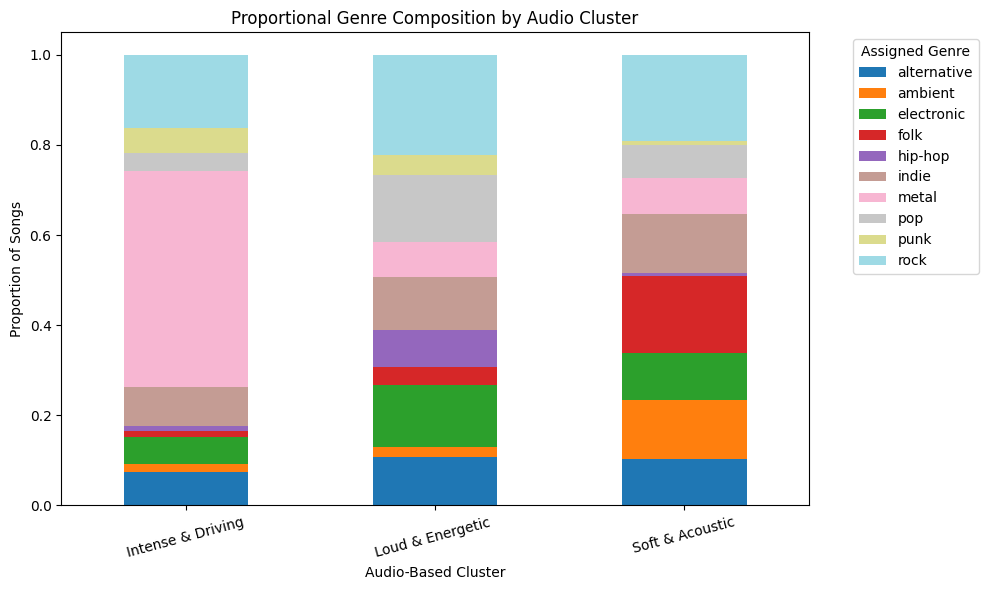

In [104]:
# Define top N genres across the whole dataset
top_genres_overall = (
    df_final['primary_genre']
    .value_counts()
    .head(10)
    .index
)
filtered_final_df = df_final[df_final['primary_genre'].isin(top_genres_overall)]

# Group by cluster and genre and count
cluster_genre_counts = (
    filtered_final_df[filtered_final_df['primary_genre'].isin(top_genres_overall)]
    .groupby(['Cluster_Description', 'primary_genre'])
    .size()
    .unstack(fill_value=0)
)

# Normalize to get proportions within each cluster
cluster_genre_props = cluster_genre_counts.div(cluster_genre_counts.sum(axis=1), axis=0)

# Plot stacked bar chart
cluster_genre_props.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    colormap='tab20'
)
plt.title('Proportional Genre Composition by Audio Cluster')
plt.xlabel('Audio-Based Cluster')
plt.ylabel('Proportion of Songs')
plt.legend(title='Assigned Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


| Cluster            | Most Dominant Genre(s)                                   |
| ------------------ | -------------------------------------------------------- |
| Loud & Energetic   | rock, pop, electronic, alternative       |
| Soft & Acoustic    | folk, ambient, jazz, classical, rock |
| Upbeat & Danceable | metal, emo, hip-hop, grindcore           |


### Step 8: Statistical Inference
Now, we have two sources of data - the clustering based on sound, and the genre-assignment done by sorting through user-made-tags. Now, ....

#### Step 8.1: Statistical Test 1: One-Way ANOVA - Do Artists in Different Clusters Evolve Differently?

Now that we’ve grouped songs by sound (not genre), we can test our central question, just slightly reworded now:

> Do artists who make different styles of music show different levels of change over time?

We measured each artist’s musical change score — which tracks how much their sound shifts across the years.

Then we grouped the artists by their cluster label and ran a statistical test to compare their average change scores.


### 📌 Hypotheses

- **Null Hypothesis (H₀):** The average musical change score is the same for all clusters. (p >= 0.05)
- **Alternative Hypothesis (H₁):** At least one cluster has a different mean musical change score. (p < 0.05)

If we reject the null, we’ll follow up with **Tukey’s HSD** to see which clusters differ.


In [105]:
# Group by artist and get their most frequent cluster
artist_clusters = df_final.groupby('artist')['Cluster_Label'].agg(
    lambda labels: Counter(labels).most_common(1)[0][0]
).reset_index().rename(columns={'Cluster_Label': 'primary_cluster'})

# Optional: map cluster label to description
cluster_names = {
    0: 'Intense & Driving',
    1: 'Loud & Energetic',
    2: 'Soft & Acoustic'
}
artist_clusters['Cluster_Description'] = artist_clusters['primary_cluster'].map(cluster_names)

# Merge with artist-level data
analysis_df = analysis_df.merge(artist_clusters[['artist', 'Cluster_Description']], on='artist', how='left')

# Group the change scores by cluster
grouped_scores = analysis_df.groupby('Cluster_Description')['musical_change_score'].apply(list)

# Prepare input for ANOVA: a list of groups
anova_input = grouped_scores.tolist()

f_stat, p_value = f_oneway(*anova_input)

print("ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
 


ANOVA Results:
F-statistic: 7.6465
p-value: 0.0005


Since our p-value was less than 0.05, we reject the null hypothesis. We now do Post-Hoc Test.

### 🔍 Tukey HSD Interpretation

Our ANOVA test showed a significant difference in musical change scores across the three clusters. To explore which pairs of clusters differ, we used Tukey’s HSD post-hoc test.

The results show:
- **Loud & Energetic** artists change significantly more over time than both **Soft & Acoustic** and **Upbeat & Danceable** artists.
- **Soft & Acoustic** artists change the least on average.

This suggests that artists in **high-energy, loud genres** (like rock or punk) tend to evolve more in their sound over time than artists in more relaxed, acoustic genres.

Even though we didn’t directly test genre names like “rock” or “folk,” these clusters reflect genre-like groupings based on audio characteristics — making our test meaningful for analyzing artistic evolution across styles.


In [106]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Make sure 'Cluster_Description' is treated as a category
analysis_df['Cluster_Description'] = analysis_df['Cluster_Description'].astype('category')

# Drop missing values (important to avoid error)
tukey_df = analysis_df[['musical_change_score', 'Cluster_Description']].dropna()

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(
    endog=tukey_df['musical_change_score'],       # dependent variable
    groups=tukey_df['Cluster_Description'],       # group labels
    alpha=0.05                                     # significance level
)

print(tukey_result.summary())


          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1           group2      meandiff p-adj   lower  upper  reject
------------------------------------------------------------------------
Intense & Driving Loud & Energetic   0.0054 0.9796 -0.0605 0.0714  False
Intense & Driving  Soft & Acoustic   0.1298  0.001  0.0448 0.2148   True
 Loud & Energetic  Soft & Acoustic   0.1243 0.0009  0.0433 0.2054   True
------------------------------------------------------------------------


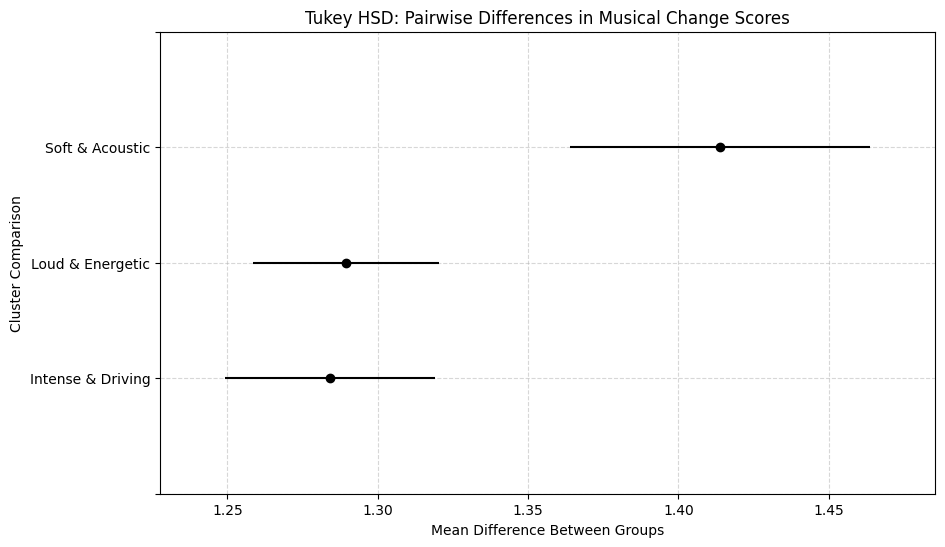

In [107]:
# Get the pairwise data from the Tukey result
tukey_result.plot_simultaneous(
    comparison_name=None,
    xlabel='Mean Difference Between Groups',
    ylabel='Cluster Comparison'
)
plt.title('Tukey HSD: Pairwise Differences in Musical Change Scores')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


The mean musical change score (dots) and 95% confidence intervals (horizontal lines) for each cluster are displayed in this Tukey HSD illustration.  

So, what does this tell us?

> Artists who make high-energy, intense music (like rock or punk) are more likely to evolve their sound over time.

In contrast, artists who focus on soft, ambient, or acoustic styles tend to stick to a consistent sound across their career.

This supports our idea that musical style — not just genre — affects how artists change.

Now, lets compare our cluster-based analysis with one based on our original genre analysis

In [108]:
# Count artists per genre
genre_counts = analysis_df['primary_genre'].value_counts()

# Keep only genres with >= 20 artists
valid_genres = genre_counts[genre_counts >= 30].index
filtered_genre_df = analysis_df[analysis_df['primary_genre'].isin(valid_genres)].copy()

# Group change scores by genre
genre_groups = filtered_genre_df.groupby('primary_genre')['musical_change_score'].apply(list)

# Prepare and run ANOVA
anova_input = genre_groups.tolist()
f_stat, p_value = f_oneway(*anova_input)

print("Genre-Based ANOVA Results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

tukey_genre_result = pairwise_tukeyhsd(
    endog=filtered_genre_df['musical_change_score'],
    groups=filtered_genre_df['primary_genre'],
    alpha=0.05
)

print(tukey_genre_result.summary())



Genre-Based ANOVA Results:
F-statistic: 3.5838
p-value: 0.0000
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
    Unknown alternative  -0.0629    1.0  -0.416  0.2901  False
    Unknown     ambient    0.044    1.0 -0.3491  0.4371  False
    Unknown       blues   0.1235    1.0 -0.3083  0.5553  False
    Unknown   classical   0.0695    1.0 -0.3722  0.5111  False
    Unknown     country  -0.1968 0.9816  -0.583  0.1894  False
    Unknown       dance  -0.0699    1.0 -0.4618   0.322  False
    Unknown  electronic   0.0613    1.0 -0.2783  0.4008  False
    Unknown         emo    0.132    1.0  -0.318   0.582  False
    Unknown        folk   0.0961    1.0 -0.2778  0.4701  False
    Unknown        funk  -0.2222 0.9831 -0.6612  0.2169  False
    Unknown      gothic   0.1707 0.9999 -0.3029  0.6442  False
    Unknown   grindcore  -0.3254 0.7891 -0.8258   0.175

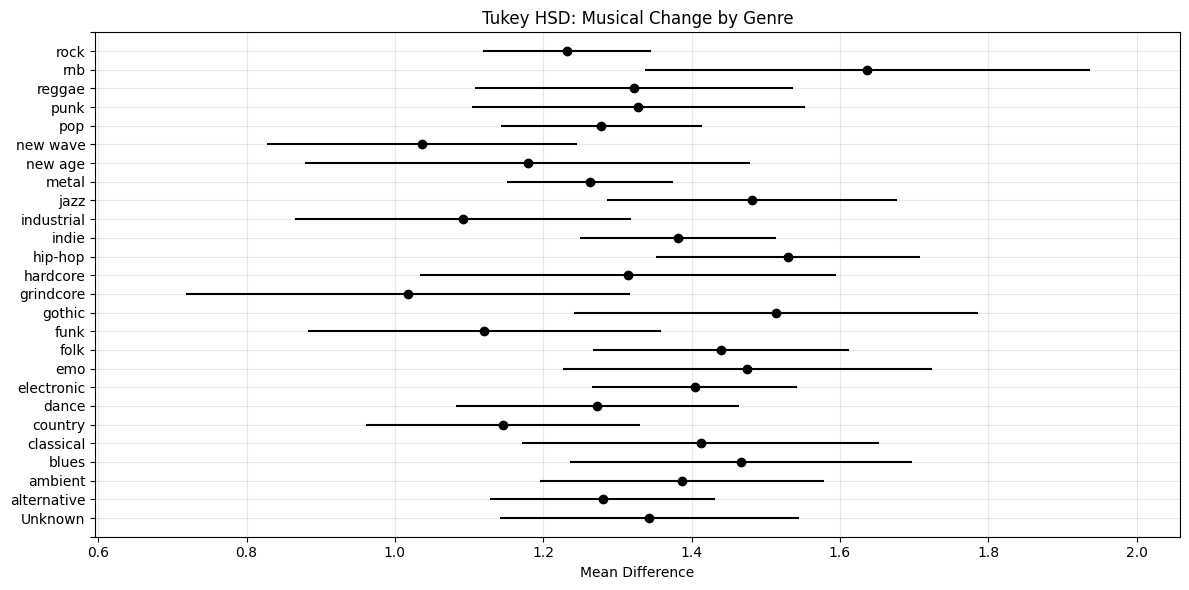

In [109]:
tukey_genre_result.plot_simultaneous(figsize=(12, 6))
plt.title("Tukey HSD: Musical Change by Genre")
plt.xlabel("Mean Difference")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [110]:
# Convert Tukey table to DataFrame
tukey_df = pd.DataFrame(data=tukey_genre_result.summary().data[1:], columns=tukey_genre_result.summary().data[0])

# Filter for significant comparisons
significant = tukey_df[tukey_df['reject'] == True]

# Check if rock or metal appears in any significant row
rock_related = significant[
    significant['group1'].str.contains('rock') | significant['group2'].str.contains('rock') |
    significant['group1'].str.contains('metal') | significant['group2'].str.contains('metal')
]

print(rock_related)


      group1 group2  meandiff   p-adj   lower   upper  reject
269  hip-hop   rock   -0.2976  0.0277 -0.5821 -0.0131    True


We ran a Tukey HSD test after ANOVA and found only a few significant genre pairs — notably, hip-hop differed from rock (p = 0.0238). Most other genre pairs showed no statistically significant difference.
TODO: go over this again



In [111]:
# Convert Tukey HSD summary to a DataFrame
tukey_df = pd.DataFrame(data=tukey_genre_result._results_table.data[1:],  # Skip header row
                        columns=tukey_genre_result._results_table.data[0])

# Show only significant results
significant_tukey = tukey_df[tukey_df['reject'] == True]

print("Significant Tukey HSD Results (Genre-Based):")
display(significant_tukey)


Significant Tukey HSD Results (Genre-Based):


,group1,group2,meandiff,p-adj,lower,upper,reject
123,country,hip-hop,0.3838,0.0229,0.0219,0.7456,True
133,country,rnb,0.4907,0.0459,0.0034,0.9781,True
166,electronic,new wave,-0.3678,0.0247,-0.7166,-0.0191,True
199,folk,new wave,-0.4027,0.0252,-0.7850,-0.0204,True
235,grindcore,hip-hop,0.5124,0.0220,0.0306,0.9942,True
245,grindcore,rnb,0.6194,0.0218,0.0374,1.2014,True
260,hip-hop,industrial,-0.4384,0.0172,-0.8439,-0.0329,True
264,hip-hop,new wave,-0.4936,0.0008,-0.8810,-0.1061,True
269,hip-hop,rock,-0.2976,0.0277,-0.5821,-0.0131,True
274,indie,new wave,-0.3452,0.0471,-0.6888,-0.0017,True


### 🔍 Very Few Genre Pairs Show Significant Differences

Out of all the genre pair comparisons, only **13 pairs** showed statistically significant differences in musical change scores.

Some examples include:

- 🎶 **Hip-hop vs. RnB** and **Grindcore vs. RnB** 
- 🌀 **Electronic/Folk vs. New Wave** 
- ⚡ **Hip-hop vs. Rock/Industrial/New Wave** 

### 🧠 But Why So Few?

Despite these outliers, the **majority of genre comparisons were not statistically significant.** That’s a key takeaway.

Here’s why:

> **Genre tags — like "pop," "indie," or "rock" — are often too vague or inconsistent.**

Two "pop" artists might sound totally different, and genre tags from sources like Last.fm are often user-generated and noisy.

### 💡 Why This Matters

This lack of clear, consistent differences between genres **justifies our shift to clustering**:

- Clusters are based on **actual audio features**, not messy human labels.
- In contrast to genre, our **cluster-based analysis produced strong, significant patterns** of evolution.

So while the genre results are “messy,” they actually tell us something important:  
👉 **Style matters more than label** when it comes to tracking musical change.


#### 8.1.2 ANOVA conclusion

To explore whether different types of artists evolve differently over time, we tested two grouping systems: traditional genre labels and our own clusters based on audio features. Both showed statistically significant differences in how much artists change - but the clustering system revealed clearer and more interpretable group differences. This suggests that clustering based on musical “feel” may capture artist evolution in a more nuanced way than genre labels alone. 

#### Step 8.2: T-Test

In [112]:
# Pick two genres to compare
genre_a = 'pop'
genre_b = 'rock'

# Filter the analysis_df
group_a = analysis_df[analysis_df['primary_genre'] == genre_a]['musical_change_score']
group_b = analysis_df[analysis_df['primary_genre'] == genre_b]['musical_change_score']

# Welch's t-test (equal_var=False)
t_stat, p_val = stats.ttest_ind(group_a, group_b, equal_var=False)

print(f"T-test comparing {genre_a} vs {genre_b} on musical change:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")


T-test comparing pop vs rock on musical change:
T-statistic: 0.809
P-value: 0.4190


In [113]:
# Pick two genres to compare
genre_a = 'classical'
genre_b = 'electronic'

# Filter the analysis_df
group_a = analysis_df[analysis_df['primary_genre'] == genre_a]['musical_change_score']
group_b = analysis_df[analysis_df['primary_genre'] == genre_b]['musical_change_score']

# Welch's t-test (equal_var=False)
t_stat, p_val = stats.ttest_ind(group_a, group_b, equal_var=False)

print(f"T-test comparing {genre_a} vs {genre_b} on musical change:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")


T-test comparing classical vs electronic on musical change:
T-statistic: 0.067
P-value: 0.9469


### Analysis

We compared musical change between pop and rock artists using a Welch's t-test. The p-value was 0.419, meaning we did not find a statistically significant difference. This suggests that although rock and pop differ in style, their degree of musical evolution is not significantly different. We performed another Welch’s t-test which compares the musical change scores of classical and electronic artists. The resulting p-value was 0.9469, indicating no statistically significant difference between the two genres. This indicates that genre isn't a sole factor in musical change.


#### Step 8.3: Chi Square - for genre and cluster 

In [114]:
# Chi-Square Test for Genre vs High/Low Musical Change
# Binarize musical_change_score
threshold = analysis_df['musical_change_score'].median()
analysis_df['change_bin'] = analysis_df['musical_change_score'] > threshold  # True = high change

# Create contingency table
contingency = pd.crosstab(analysis_df['primary_genre'], analysis_df['change_bin'])

# Run chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print("Chi-Square Test: Genre vs High/Low Musical Change")
print(f"Chi2 statistic = {chi2:.2f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p:.4f}")


Chi-Square Test: Genre vs High/Low Musical Change
Chi2 statistic = 87.30
Degrees of freedom = 37
P-value = 0.0000


In [115]:
from scipy.stats import chi2_contingency

# Binarize musical_change_score (if not already done)
threshold = analysis_df['musical_change_score'].median()
analysis_df['change_bin'] = analysis_df['musical_change_score'] > threshold  # True = high change

# Ensure 'Cluster_Description' exists
if 'Cluster_Description' not in analysis_df.columns:
    artist_clusters = df_final.groupby('artist')['Cluster_Label'].agg(
        lambda labels: Counter(labels).most_common(1)[0][0]
    ).reset_index().rename(columns={'Cluster_Label': 'primary_cluster'})
    
    cluster_names = {
        0: 'Intense & Driving',
        1: 'Loud & Energetic',
        2: 'Soft & Acoustic'
    }
    artist_clusters['Cluster_Description'] = artist_clusters['primary_cluster'].map(cluster_names)
    analysis_df = analysis_df.merge(artist_clusters[['artist', 'Cluster_Description']], on='artist', how='left')

# Create contingency table: Cluster × High/Low Change
contingency = pd.crosstab(analysis_df['Cluster_Description'], analysis_df['change_bin'])

# Run Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency)

# Print results
print("Chi-Square Test: Cluster vs High/Low Musical Change")
print(f"Chi2 statistic = {chi2:.2f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p:.4f}")

if p < 0.05:
    print("✅ Significant: Clusters are associated with musical change levels.")
else:
    print("❌ Not significant: No strong link between clusters and change.")


Chi-Square Test: Cluster vs High/Low Musical Change
Chi2 statistic = 8.36
Degrees of freedom = 2
P-value = 0.0153
✅ Significant: Clusters are associated with musical change levels.


### 📊 Chi-Square Test Interpretation

We tested whether certain **genres** were more likely to have artists with **high musical change scores** (above median). The result:

- **Chi² = 87.30**
- **p < 0.0001**

This was statistically significant, suggesting that **musical change is not evenly distributed across genres**. Some genres are more likely to contain evolving artists than others. This supports our main hypothesis: **genre influences musical evolution**.


Step 8.4: Spearman Correlation

In [116]:

artist_avg_year = df_final.groupby('artist')['year'].mean().reset_index()
artist_avg_year.rename(columns={'year': 'avg_release_year'}, inplace=True)


analysis_df = pd.merge(analysis_df, artist_avg_year, on='artist')

corr, p_val = stats.spearmanr(analysis_df['avg_release_year'], analysis_df['musical_change_score'])

print("Spearman Correlation: Avg Artist Year vs Musical Change")
print(f"Spearman ρ = {corr:.3f}")
print(f"P-value = {p_val:.4f}")


Spearman Correlation: Avg Artist Year vs Musical Change
Spearman ρ = 0.206
P-value = 0.0000


### 📈 Spearman Correlation Interpretation

We also tested whether **newer artists** (based on average release year) tend to **evolve more** musically over time.

- **Spearman ρ = 0.206**
- **p < 0.0001**

This is a **positive and significant correlation**, meaning more recent artists are slightly more likely to change their musical style across years. This might reflect how music trends, technology, or genre fluidity have increased over time.


## Insights and Conclusions

At the end of the Notebook, you must include a summary of the key findings and insights that were generated from the
project. Make sure that all conclusions are backed up with evidence and statiscal tests from the empirical data.
Keep in mind that you must produce a cohesive data narrative about your dataset. That is, the process that you do
in the project, including the data mining and statistical inference requirements, must tie together into a meaningful story
centered around your general research question. The insights and conclusions at the end of the Notebook must provide a
satisfying resolution to the narrative you are telling.

## GENERATIVE AI USE

During the preparation of this work the author(s) used CHATGPT and GOOGLE GEMINI for the following purposes:
- formatting
- proofreading
- aid in understanding concepts
- mental support

After using this tool/service, the author(s) reviewed and edited the content as needed and take(s) full responsibility for the content of the publication.